<title>
    # A model for binary multivariate time series


<h1 align=center> A model for binary multivariate time series generation </center>

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image
from scipy.stats import ttest_ind_from_stats, spearmanr
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter 
import tqdm
import math
import xarray as xr
%matplotlib inline


## Data generation mechanism

In [3]:
def sample(i :int, T :int, d :int): 
    
    """
    Data generating function. Returns A, B,sigma as matrices, the sampled data as a tensor, and the latent state
    data as a tensor. 
    """

    A = 0.3*np.identity(d) + 0.1*np.random.randn(d,d)
    B = 0.8*np.identity(d) + 0.1*np.random.randn(d,d)
    random_matrix = 0.7*np.random.randn(d,d)
    sigma = np.dot(random_matrix,random_matrix.T)
    
    x_data = np.zeros((i,d,T))
    z_data = np.zeros((i,d,T))
    #dimension 0: individus, dimension 1: features, dimension 2: temps
    
    
    #initialization 
    x = np.random.randint(0,2,size=(d,i))
    z = np.random.randn(d,i)
    
    for t in np.arange(T): 
        z = A@x + B@z + np.random.multivariate_normal(mean=np.zeros(d),cov=sigma,size=i).T
        p = stats.norm.cdf(z)
        x = np.random.binomial(1,p,size=(d,i))
        x_data[:,:,t] = x.T
        z_data[:,:,t] = z.T
        
    return A,B,sigma,x_data,z_data
        
        
        

    

    

In [5]:
T=900
d=4
A,B,sigma,test_data,z_data = sample(100,T,d)

Text(0.5, 0, 'Time')

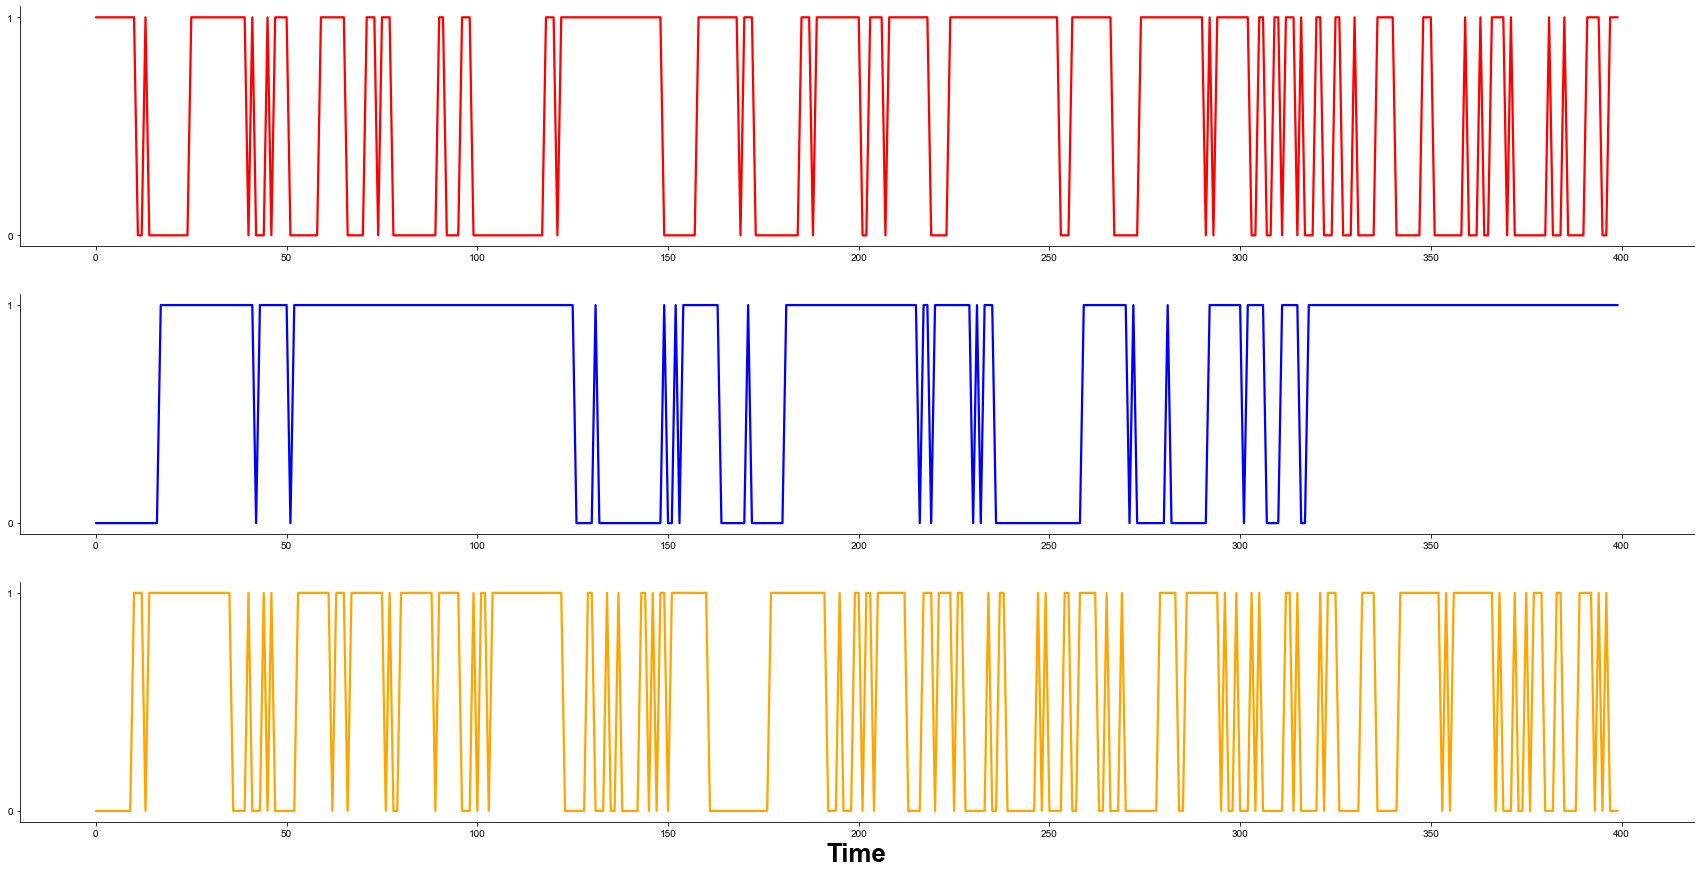

In [6]:
f,ax=plt.subplots(3,1,figsize=(30,15))

sns.set_context('talk')
sns.set_style('white')
ax[0].plot(test_data[4,0,500:], c='red')
ax[1].plot(test_data[4,1,500:], c='blue')
ax[2].plot(test_data[4,2,500:], c='orange')

for i in [0,1,2]:
    ax[i].set_yticks([0,1])
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    
ax[2].set_xlabel('Time', fontsize='x-large', fontweight='bold')

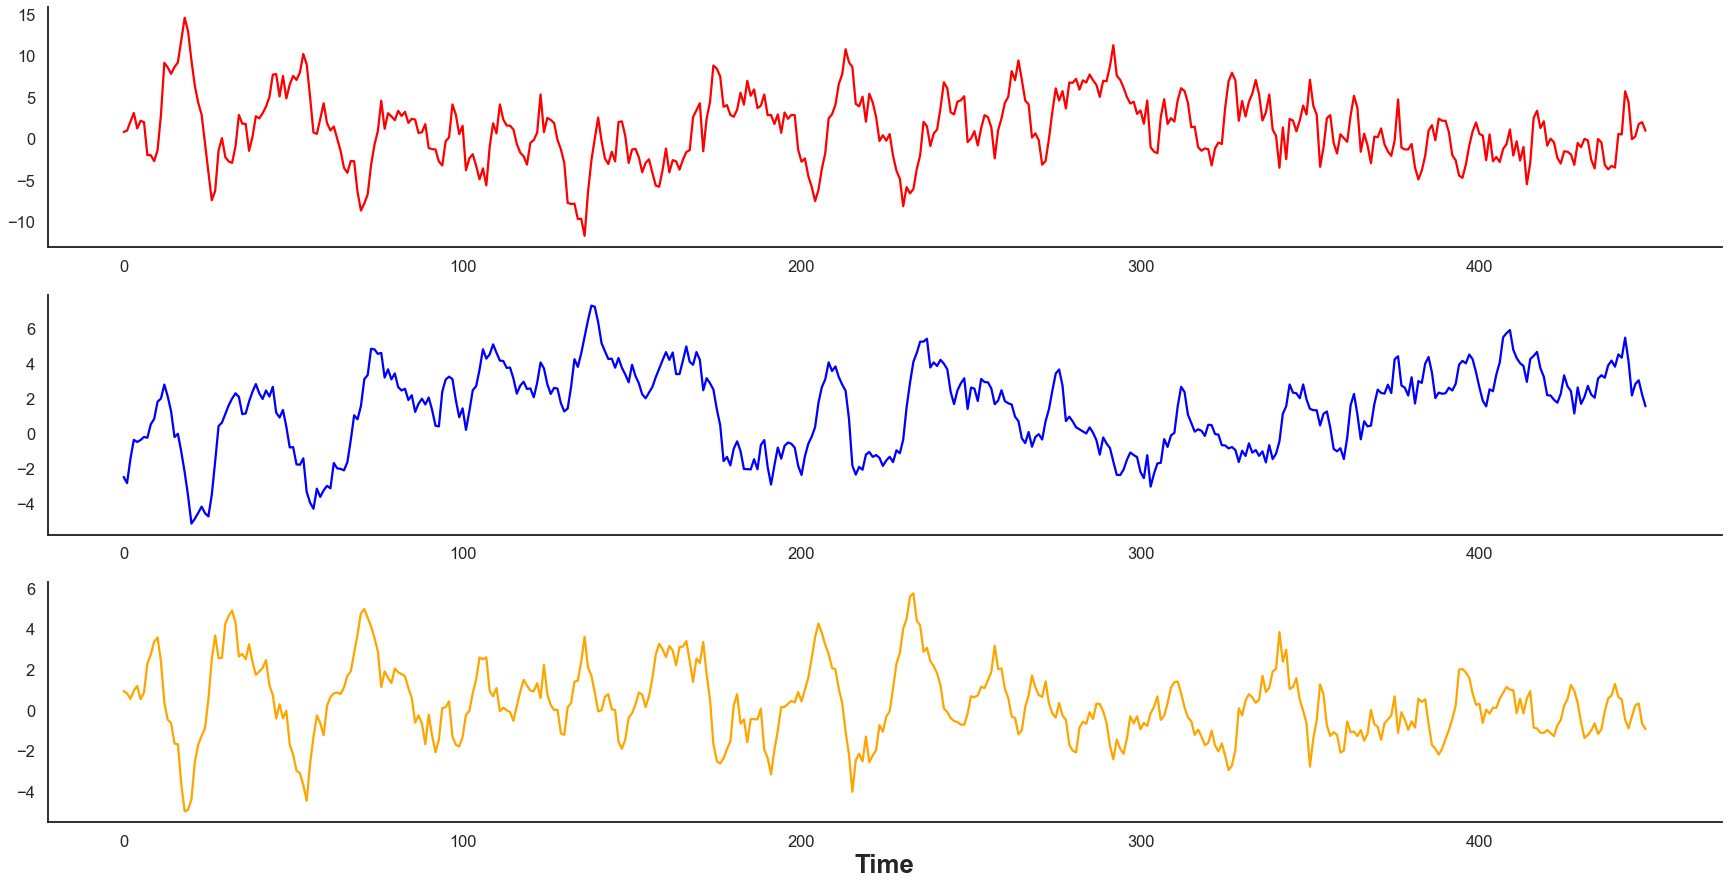

In [7]:
f,ax=plt.subplots(3,1,figsize=(30,15))

sns.set_context('talk')
sns.set_style('white')
ax[0].plot(z_data[4,0,int(T/2):], c='red')
ax[1].plot(z_data[4,1,int(T/2):], c='blue')
ax[2].plot(z_data[4,2,int(T/2):], c='orange')

ax[2].set_xlabel('Time', fontsize='x-large', fontweight='bold')

for i in [0,1,2]:
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)


<AxesSubplot:>

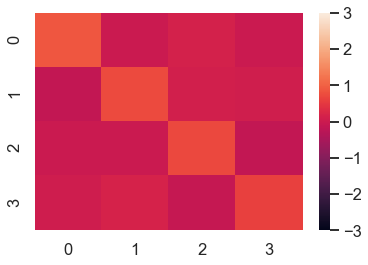

In [8]:
sns.heatmap(B,vmax=3,vmin=-3)

<AxesSubplot:>

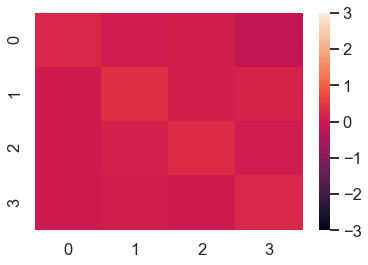

In [9]:
sns.heatmap(A,vmax=3,vmin=-3)

## Mean field approximation 

### Utils functions for mu gradient

In [10]:
def approx_mu_grad(var): 
    """
    Computes the full sum term in the mu gradient of the ELBO via MCMC approximation.
    """

    mu = var[0:d]
    sigmas = var[d:]
        
    epsilon = 1e-3
    
    #draw = np.random.randn(m,len(mu))
    transformed_draw = draw*sigmas + mu
    approx_1 = stats.norm.pdf(transformed_draw)/(np.maximum(stats.norm.cdf(transformed_draw),epsilon))
    approx_2 = stats.norm.pdf(transformed_draw)/np.maximum((1-stats.norm.cdf(transformed_draw)),epsilon)
    approx_1 = approx_1.mean(axis=0)
    approx_2 = approx_2.mean(axis=0)
    data_1 = np.multiply(data.sum(axis=2),approx_1).sum(axis=0)
    data_2 = np.multiply((1-data).sum(axis=2),approx_2).sum(axis=0)
    full_data = data_1 + data_2
    
    return full_data

In [11]:
def elbo_mu_grad(var):
    
    """
    Computes the gradient of the ELBO w.r.t. sigma. Returns a (d,) array. 
    """
    
    mu = var[0:d]
    sigmas = var[d:]
    
    quadratic_term = (-T*N*mu.T@((np.identity(d)-B).T)@sigma_inv@(np.identity(d)-B)).reshape(d,1)
        
    time_sum = (-np.matmul(A,data[:,:,:-1]).sum(axis=(2,0)).T@sigma_inv@(B-np.identity(d))).reshape(d,1)
        
    exp_sum = approx_mu_grad(var).reshape(d,1)
    
    return quadratic_term + time_sum + exp_sum

### Utils functions for sigma gradient

In [12]:
def approx_sigma_grad(var): 
    
    """
    Computes the full sum term in the mu gradient of the ELBO via MCMC approximation. 
    """
    
    d = data.shape[1]

    mu = var[0:d]
    sigmas = var[d:]
    T = data.shape[2]
    
    epsilon = 1e-3
        
    #draw = np.random.randn(m,len(mu))
    transformed_draw = draw*sigmas + mu
    approx_1 = draw*stats.norm.pdf(transformed_draw)/(np.maximum(stats.norm.cdf(transformed_draw),epsilon))
    approx_2 = draw*stats.norm.pdf(transformed_draw)/(np.maximum(1-stats.norm.cdf(transformed_draw),epsilon))
    approx_1 = approx_1.mean(axis=0)
    approx_2 = approx_2.mean(axis=0)
    data_1 = np.multiply(data.sum(axis=2),approx_1).sum(axis=0)
    data_2 = np.multiply((1-data).sum(axis=2),approx_2).sum(axis=0)
    full_data = data_1 - data_2
    
    return full_data

In [13]:
def elbo_sigma_grad(var): 
    
    """
    Computes the gradient of the ELBO w.r.t. sigma. Returns a (d,) array. 
    """
    
    mu = var[0:d]
    sigmas = var[d:]
    
    diag_term = -(T*N*np.diag(sigma_inv+B.T@sigma_inv@B)*sigmas).reshape(d,1)
    entropy_term = -((T*N)/sigmas).reshape(d,1)
    exp_sum = approx_sigma_grad(var).reshape(d,1)
    
    return diag_term + entropy_term + exp_sum

### Other utils

In [14]:
def compute_expectation(var): 
    
    """
    Approximates the full sum term in the ELBO. Returns a scalar.
    """
    
    mu = var[0:d]
    sigmas = var[d:]
    epsilon = 1e-3
    
    
    #draw = np.random.randn(m,len(mu))
    transformed_draw = draw*sigmas + mu
    approx_1 = np.log(np.maximum(stats.norm.cdf(transformed_draw),epsilon))
    approx_2 = np.log(np.maximum(1-stats.norm.cdf(transformed_draw),epsilon))
    approx_1 = approx_1.mean(axis=0)
    approx_2 = approx_2.mean(axis=0)
    data_1 = np.multiply(data.sum(axis=2),approx_1).sum(axis=0)
    data_2 = np.multiply((1-data).sum(axis=2),approx_2).sum(axis=0)
    full_data = data_1 + data_2
    return full_data.sum()
    

In [15]:
def elbo(var):
    
    """
    Computes the ELBO(evidence lower bound) of the model. Returns -ELBO, a scalar, in order to cast the maximization
    problem as a minimization problem.
    """
    
    mu = var[0:d]
    sigmas = var[d:]
    
    entropy_term = -(T*N/2)*(d*np.log(2*math.pi)+d*np.log(2*math.pi*math.e)+np.linalg.slogdet(sigma)[1]+2*np.log(sigmas).sum())
    
    expectation_term = compute_expectation(var)
    
    bilinear_term = -(T*N/2)*mu.T@(sigma_inv - 2*sigma_inv@B + B.T@sigma_inv@B)@mu
    
    norm_term = -1/2*(np.matmul(A,data[:,:,:-1]).sum(axis=(2,0))).T@sigma_inv@(np.matmul(A,data[:,:,:-1]).sum(axis=(2,0)))
    
    time_sum = (-(np.matmul(A,data[:,:,:-1]).sum(axis=(2,0)).T)@sigma_inv@(B-np.identity(d)))@mu
    
    diag_term = -T*N/2*(np.diag(sigma_inv+B.T@sigma_inv@B)*(sigmas**2)).sum()
    
    elbo_value = -float((entropy_term + expectation_term + diag_term + time_sum + norm_term))
        
    return 1/N*elbo_value

In [16]:
def full_jacobian(var): 
    
    """
    Util function that returns minus the full jacobian of the ELBO (needed for scipy.optimize). 
    """
    
    mu_grad = elbo_mu_grad(var)
    sigma_grad = elbo_sigma_grad(var)
    
    full_grad = np.array([mu_grad,sigma_grad]).reshape((2*d,))
    
    return -1/N*full_grad

### Optimization with SCIPY.OPTIMIZE

In [17]:
import scipy.optimize as optim
import scipy.stats as stats

In [18]:
d = 3
N=100
T= 50

In [19]:
A,B,sigma,data,latent_state = sample(i=N,T=T,d=d)

In [20]:
sigma_inv = np.linalg.inv(sigma)

In [22]:
draw = np.random.randn(400,d)

In [23]:
scipy.optimize.minimize(elbo,x0 = 6*np.ones(2*d),jac=full_jacobian, method='bfgs',bounds=[None,None,None,0,0,0])


/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


      fun: nan
 hess_inv: array([[ 8.01006622e-01,  3.30357136e-01,  6.69775534e-02,
         2.62384188e-01,  4.22801719e-04,  4.83356566e-04],
       [ 3.30357136e-01,  4.51842579e-01, -1.11067979e-01,
        -4.24120110e-01, -3.33571768e-04, -8.35398365e-04],
       [ 6.69775534e-02, -1.11067979e-01,  9.77511237e-01,
        -8.32635137e-02, -1.24476322e-04, -4.84450407e-05],
       [ 2.62384188e-01, -4.24120110e-01, -8.32635137e-02,
         1.12054843e+00,  1.14422524e-03,  2.11526734e-03],
       [ 4.22801719e-04, -3.33571768e-04, -1.24476322e-04,
         1.14422524e-03,  1.14489882e-04,  8.66366914e-06],
       [ 4.83356566e-04, -8.35398365e-04, -4.84450407e-05,
         2.11526734e-03,  8.66366914e-06,  7.93913923e-05]])
      jac: array([ 1.80326215e+02, -2.64304858e+02, -5.51205057e+01, -2.51019438e+02,
        3.11602820e+04,  9.03323269e+04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 22
      nit: 4
     njev: 22
   status: 2
  

In [24]:
draw = np.random.randn(1000,d)
print(scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 0.9*np.ones(2*d)))
print(scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 1*np.ones(2*d)))
print(scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 2*np.ones(2*d)))
print(scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 3*np.ones(2*d)))

347.5583295880621
385.4426057513536
767.4156901798635
1151.584254849382


### CA optimization 

The cell bellow performs coordinate-wise optimization.

In [28]:
#Max iterations of coordinate descent and max iterations for every gradient descent within coordinate descent
max_it = 40
max_it_gd = 1000


#Initialization
variables = 4*np.ones(2*d) 

#Matrices to save values

variables_track = np.zeros((2*d,max_it*max_it_gd))

elbo_track = np.zeros(max_it)

for iteration in np.arange(max_it):
    
    optimization_order = np.random.permutation(np.arange(2*d))
    
    for i in optimization_order:
        
        for it in np.arange(max_it_gd):
            
            draw = np.random.randn(400,d)
            
            grad_noise = np.sqrt(0.0001/((iteration*max_it_gd + it + 1)**(0.55)))*np.random.randn(1)
            
            if i in np.arange(d,2*d):
                
                #This loop is for optimization of the variance parameters. 
                
                lr=0.00001/(iteration*max_it_gd + it + 1)
                
                #Gradient (as well as ELBO) is normalized by the number of individuals.
                
                grad = (-1/N)*elbo_sigma_grad(variables)[i-d]
                
                variables[i] = np.maximum(variables[i] - lr*grad + grad_noise,1e-18)
                
                
            else: 
                
                #This loop is for optimization of the mean parameters. 
                
                lr=0.001
                
                grad = (-1/N)*elbo_mu_grad(variables)[i]
                
                variables[i] = variables[i] - lr*grad + grad_noise
        
            variables_track[i,iteration*max_it_gd+it] = variables[i]
    
    elbo_track[iteration] = elbo(variables) 
    
    if iteration%2 ==0:
        
        print('Iteration ', iteration, ' completed.')
        print('ELBO value:', elbo_track[iteration])
        print('Current parameters values:', variables)
        
        

Iteration  0  completed.
ELBO value: 4476323.459662701
Current parameters values: [4.98881351 4.00128835 4.19872584 3.9444795  2.01373298 1.30296632]
Iteration  2  completed.
ELBO value: 4469561.77071253
Current parameters values: [5.08529366 3.98922204 4.34764097 3.9475117  1.80913452 1.13292259]
Iteration  4  completed.
ELBO value: 4466507.1739783855
Current parameters values: [5.07086561 3.97859011 4.33642224 3.85664343 1.79767459 0.96258192]
Iteration  6  completed.
ELBO value: 4464213.223667295
Current parameters values: [5.04271557 3.97820741 4.26539138 3.87109548 1.71709975 0.89269718]
Iteration  8  completed.
ELBO value: 4464178.006389152
Current parameters values: [5.03245983 3.97518011 4.2626245  3.85586314 1.69596224 0.91487708]
Iteration  10  completed.
ELBO value: 4462476.0307676755
Current parameters values: [5.0259069  3.97164862 4.25334065 3.89225438 1.62582146 0.86646009]
Iteration  12  completed.
ELBO value: 4461934.9179598065
Current parameters values: [5.01467035 3.

In [32]:
print(variables)

[4.96486671 3.96037957 4.12349329 3.88625576 1.47718836 0.73079205]


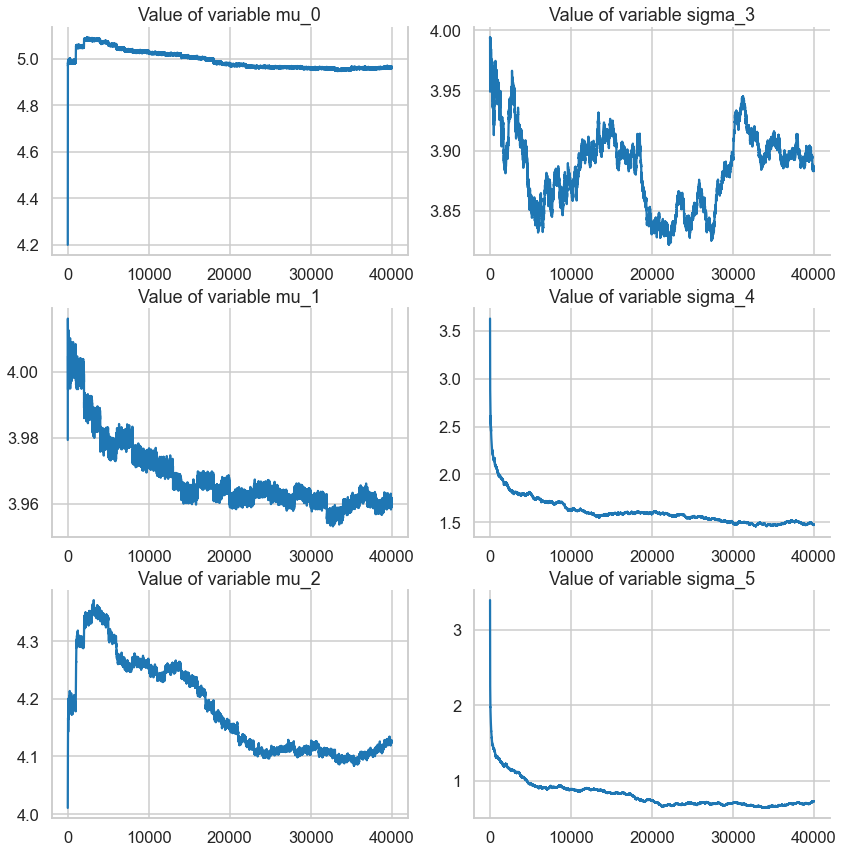

In [33]:
f,ax = plt.subplots(d,2,figsize=(12,12))
f.tight_layout()

for i in np.arange(2*d):
    
    sns.set_style('whitegrid')
    
    if i < d:
        ax[i,0].plot(variables_track[i,:], label='Value')
        ax[i,0].set_title('Value of variable mu_{}'.format(i))
        ax[i,0].spines["top"].set_visible(False)
        ax[i,0].spines["top"].set_visible(False)
    else:
        ax[i-d,1].plot(variables_track[i,:], label='Value')
        ax[i-d,1].set_title('Value of variable sigma_{}'.format(i))
        ax[i-d,1].spines["right"].set_visible(False)
        ax[i-d,1].spines["top"].set_visible(False)

[4476323.4596627  4472623.42282719 4469561.77071253 4467744.10932581
 4466507.17397839 4464994.45526968 4464213.22366729 4464137.00614851
 4464178.00638915 4462748.28322213 4462476.03076768 4462654.76557868
 4461934.91795981 4461733.69820655 4461519.95250925 4461648.6829768
 4461486.02854659 4460725.92135194 4460227.7484259  4460366.97526959
 4459584.35651841 4459579.65574011 4459463.34907074 4459339.65619245
 4459324.1138773  4459400.52399692 4459224.90851018 4459041.21479191
 4458604.55735976 4458641.8351901  4458610.10428268 4458059.64729709
 4457954.84155033 4457735.46413594 4457798.43032426 4458236.76030577
 4458617.87108025 4458891.96053326 4458379.99571282 4458668.79077796]


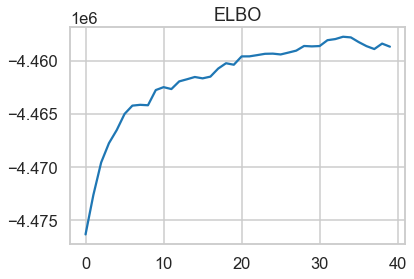

In [35]:
plt.plot(-elbo_track)
plt.title('ELBO')

print(elbo_track)

### Vanilla GD

The cell bellow performs vanilla gradient descent for maximization of the ELBO. 

In [36]:
#Max iterations of coordinate descent and max iterations for every gradient descent within coordinate descent

max_it_gd = 4000
lr=0.000001

#Initialization
variables = 4*np.ones(2*d) 

#Matrices to save values

variables_track = np.zeros((2*d,max_it_gd))

elbo_track = np.zeros(max_it_gd)

for it in np.arange(max_it_gd):

    draw = np.random.randn(400,d)

    grad_noise = np.sqrt(0.00001/((it + 1)**(0.55)))*np.random.randn(1)
    
    gradient = full_jacobian(variables)
    
    variables = variables - lr*gradient + grad_noise


    variables_track[:,it] = variables
    elbo_track[it] = elbo(variables) 

    if it%100 ==0:

        print('Iteration ', it, ' completed.')
        print('ELBO value:', elbo_track[it])
        print('Current parameters values:', variables)

Iteration  0  completed.
ELBO value: 4636723.102707006
Current parameters values: [4.00196706 4.00145134 4.00171244 4.00075523 3.96520561 3.93953078]
Iteration  100  completed.
ELBO value: 4460921.448809814
Current parameters values: [4.03401789 3.98313446 4.00878776 3.91348872 1.59097297 0.82701814]
Iteration  200  completed.
ELBO value: 4445858.116389111
Current parameters values: [4.04568755 3.94731795 3.99613097 3.80938511 0.62705084 0.15899429]


/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


Iteration  300  completed.
ELBO value: nan
Current parameters values: [ 4.06357855  3.92088083  3.99110983  3.7152268   0.23937566 -0.02281474]
Iteration  400  completed.
ELBO value: 4443341.524025264
Current parameters values: [4.07230094e+00 3.88888035e+00 3.97881655e+00 3.61586935e+00
 6.27043013e-02 2.75946534e-04]
Iteration  500  completed.
ELBO value: 4443368.66669315
Current parameters values: [4.07658267 3.8557218  3.96375001 3.51569922 0.01685658 0.00636531]
Iteration  600  completed.
ELBO value: nan
Current parameters values: [ 4.08285885  3.82780586  3.9523167   3.42117626 -0.05344793  0.10142193]
Iteration  700  completed.
ELBO value: nan
Current parameters values: [ 4.0924188   3.80593037  3.94555597  3.33324848  0.03649327 -0.13435641]
Iteration  800  completed.
ELBO value: nan
Current parameters values: [ 4.10750138  3.7918765   3.94549165  3.25382793  0.16438478 -0.03554857]
Iteration  900  completed.
ELBO value: nan
Current parameters values: [ 4.11106947  3.76866519  

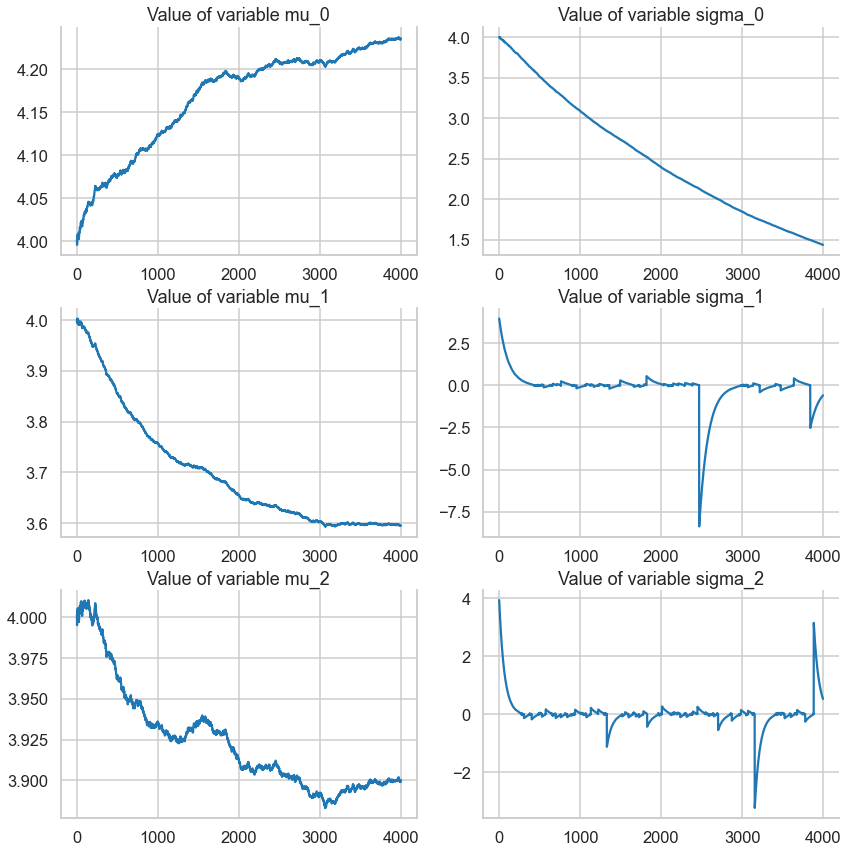

In [38]:
f,ax = plt.subplots(d,2,figsize=(12,12))
f.tight_layout()

for i in np.arange(2*d):
    
    sns.set_style('whitegrid')
    
    if i < d:
        ax[i,0].plot(variables_track[i,:], label='Value')
        ax[i,0].set_title('Value of variable mu_{}'.format(i))
        ax[i,0].spines["top"].set_visible(False)
        ax[i,0].spines["top"].set_visible(False)
    else:
        ax[i-d,1].plot(variables_track[i,:], label='Value')
        ax[i-d,1].set_title('Value of variable sigma_{}'.format(i-3))
        ax[i-d,1].spines["right"].set_visible(False)
        ax[i-d,1].spines["top"].set_visible(False)



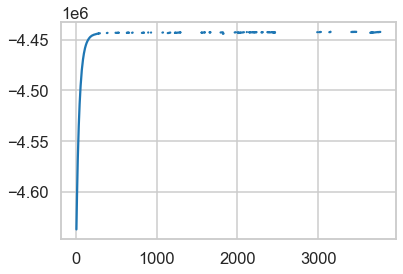

In [39]:
plt.plot(-elbo_track)